In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.cosmology import Planck18
import astropy.units as u
import pandas as pd
from scipy.integrate import cumtrapz
import seaborn as sns
import tqdm

# My favorites:
sns.set_palette('colorblind')
sns.set_context('notebook')
sns.set_style('ticks')

Here I am assuming that you have a grid of runs at different metallicity, $Z$, which is uniformly spaced in $\ln Z$.  At each metallicity, $Z_i$, you have run $N_i$ stellar evolutions, accounting for a total of $M_i$ solar masses of star formation, and produced $n_i$ "objects of interest" (BBH mergers, say).  I am assuming that the masses of your evolving systems are drawn from the desired mass distribution at each metallicity.  Thus, each object of interest carries with it $M_i / n_i$ solar masses of star formation.

What we want is to produce formation redshifts and metallicities drawn from these simulations with a density proportional to the metallicity-specific star formation rate:
$$
p\left( z, Z \right) = p\left( Z \mid z \right) p\left( z \right),
$$
where
$$
p\left( z \right) \propto \frac{\left( 1 + z \right)^{2.7}}{1 + \left( \frac{1+z}{1+1.9} \right)^{5.6}} \frac{\mathrm{d} V}{\mathrm{d} z}
$$
is the [Madau & Dickinson (2014)](http://www.annualreviews.org/doi/10.1146/annurev-astro-081811-125615) SFR and 
$$
p\left( Z \mid z \right) = \frac{1}{\sqrt{2\pi} \sigma_Z(z) Z} \exp\left( -\frac{\left( \log Z - \mu_Z(z) \right)^2}{2 \sigma_Z^2(z)} \right)
$$
is an assumed log-normal metallicity distribution with $\mu_Z(z)$ the mean (log) metallicity and $\sigma_Z(z)$ the s.d. of the (log) metallicity at each redshift.

Along the way, we want to track the total amount of star formation associated with our set of mergers so we can later normalize the rate density.

First, some utility functions:

In [3]:
def md(z):
    """The Madau-Dickinson SFR normalized to (approximately) 1 at `z = 0`"""
    
    return (1+z)**2.7/(1 + ((1+z)/(1+1.9))**5.6)

def md_zs():
    """A generator that returns redshifts of formation drawn from the M-D SFR."""
    zmax = 20
    zs = expm1(linspace(log(1), log(1+zmax), 1024))
    pzs = (1+zs)**2.7/(1 + ((1+zs)/(1+1.9))**5.6)*Planck18.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value
    czs = cumtrapz(pzs, zs, initial=0) # Cumulative distribution
        
    while True:
        yield interp(np.random.uniform(low=0, high=czs[-1]), czs, zs)

The output looks sensible:

Text(0, 0.5, '$p_{\\mathrm{MD}}(z)$')

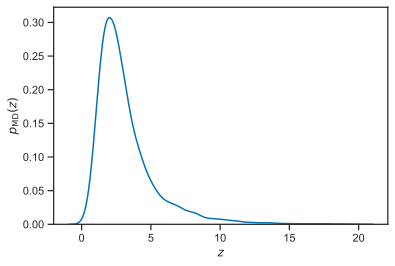

In [4]:
zs = array([z for (z,i) in zip(md_zs(), range(10000))]) # Use range to terminate the otherwise-infinite draws from `md_zs`
sns.kdeplot(zs)
xlabel(r'$z$')
ylabel(r'$p_{\mathrm{MD}}(z)$')

Now, a quick tutorial on MCMC.  The goal of an MCMC is to produce a sequence of samples $x_i, i = 1, \ldots$ that are drawn from a target distribution, usually labeled $\pi(x)$.  The way this is done is by evolving points in the sequence via a random "proposal" that produces a draw $y$ from some probability distribution that can depend on $x$: $y \sim p\left( y \mid x \right)$, and then accepting or rejecting the proposed move to $y$ from $x$ probabilistically.  (A common choice is to take the current point in the sequence and draw $y$ from a Gaussian distribution centered on $x$, but there are an infinite number of possible proposals.)  For target density $\pi$ and proposal density $p \left( \mid \right)$ the probability of acceptance is 
$$
P_\mathrm{accept}\left( y \mid x \right) = \min\left( \frac{\pi\left( y \right)}{\pi \left( x \right)} \frac{p\left( x \mid y \right)}{p\left( y \mid x \right)}, 1 \right)
$$
If $y$ is accepted, it becomes the next point in the chain; otherwise $x$ is repeated.

The first ratio favors points $y$ that have a higher target density; the second ratio favors transitions to points $y$ from which it is easier to "return" to $x$ (such transitions have "lower risk").

We can see that $\pi$ is the equilibrium density for such a "transition kernel."  If $x$ and $y$ are drawn from $\pi$, the rate of transitions from $x$ to $y$ is equal to the rate of transitions from $y$ to $x$ on average:
$$
P(x \to y) \pi(x) = P_\mathrm{accept}\left( y \mid x \right) p\left( y \mid x \right) \pi\left(x\right) = P_\mathrm{accept}\left( x \mid y \right) p\left( x \mid y \right) \pi(y) = P\left( y \to x \right) \pi(y)
$$

We can think of the suite of pop synth simulations at different $Z$ as a proposal distribution for an MCMC; the output of the MCMC should be distributed according to
$$
p\left( z, Z \right) = p\left( Z \mid z \right) p\left(z \right).
$$
Since the simulations do not have an intrinsic redshift (i.e. we are assuming that the synthesized population does not depend on redshift once the metallicity is known), we can augment each simulation draw with a $z$ that comes from the Madau & Dickinson (2014) distribution; when the proposal distribution is equal to the target distribution, both drop out of the acceptance ratio, which is convenient.  Then we need to choose how to draw a system of interest from the metallicity grid.

First, consider a choice that picks a grid point $i$ in metallicity uniformly at random, and then chooses a system of interest from that metallicity $j$ also uniformly at random.  We assign system $j$ a particular metallicity drawn uniformly at random within bin $i$ (note: this is *dangerous* if the "physics" of star formation varies a lot over the metallicity bin $i$; in that case it would be better to draw the metallicity randomly in the *input* simulations, or else *fix* $Z$ to whatever was chosen in the sims; this latter option will generate discrete "stripes" in the re-weighting which look bad, but at least is physically consistent.) The implied density of the corresponding ZAMS draw in $Z$ is 
$$
p\left( Z \mid i, j \right) \simeq \frac{N_i}{n_i \Delta Z_i},
$$
where $\Delta Z_i$ is the width of the metallicity bin corresponding to grid point $i$.  The factor $N/n$ is required because we draw one system of interest (from the $n_i$ options) from bin $i$, but this can correspond to more than one ZAMS system at $Z = Z_i$; and we want to re-weight the *ZAMS* draws to the target distribution in $Z$, so we need to keep track of the density of ZAMS draws per BBH draw (which is $N_i/n_i$).

An MCMC implementing this idea would accept a transition from system $i$, $j$ at redshift $z$ to one at $i'$, $j'$ and redshift $z'$ according to 
$$
P_\mathrm{accept} \left( i', j', z' \mid i, j, z \right) = \min \left( \frac{p\left( Z_{i'} \mid z' \right)}{p\left( Z_i \mid z \right)} \frac{N_i n_{i'} \Delta Z_{i'}}{N_{i'} n_i \Delta Z_i} , 1 \right)
$$

Aside: another way to intrepret this is that we want to re-weight to the *metallicity of formation for the objects of interest*, which is proportional to the star formation metallicity ($p\left( Z \mid z \right)$) times the *efficiency* of forming objects of interest at that metallicity, estimated by $n / N$; the acceptance probability above involves only this product of terms.  (In this picture, once we have chosen the bin $i$, we will get a BBH at formation metallicity $Z$ with probability 1, so we only need to know the target density at $Z$, which is $p\left( Z \mid z \right) n/N$; the proposal ratio is 1.)

This idea is implemented in the following code:

In [5]:
def mergers_uniform_proposal(Zs, dZs, Ns, ns, mu_logZ, sigma_logZ):
    """Generator for draws from a log-normal metallicity distribution and Madau-Dickinson SFR given populations synthesized on a regular grid of metallicity.
    
    :param Zs: The center of each metallicity bin.
    
    :param dZs: The width of each metallicity bin.
    
    :param Ns: The total number of ZAMS draws in each metallicity bin.
    
    :param ns: The number of system of interest within each metallicity bin.
    
    :param mu_logZ: Function giving the mean (natural) log metallicity at redshift `z`: `mu_logZ(z)`.
    
    :param sigma_logZ: Function giving the standard deviation of the (natural) log metallicity at redshift `z`: `sigma_logZ(z)`.
    
    :return: Yields a series of `(i, j, z, Z)` where `i` is the metallicity bin, `j` is the index of the system within that bin, `z` is the redshift of formation, and `Z` is the randomly-assigned metallicity within the bin `i`.    
    """
    
    def log_pi(Z, z):
        mu = mu_logZ(z)
        sigma = sigma_logZ(z)
        
        return -log(Z) - log(sigma) - 0.5*square((log(Z) - mu)/sigma)
    
    Nbin = len(Zs)
    
    i = np.random.randint(Nbin)
    j = np.random.randint(ns[i])
    z = next(md_zs())
    Z = np.random.uniform(low=Zbins[i], high=Zbins[i+1])
    
    for zp in md_zs():
        ip = np.random.randint(Nbin)
        jp = np.random.randint(ns[ip])
        Zp = np.random.uniform(low=Zbins[ip], high=Zbins[ip+1])
        
        log_Pacc = log_pi(Zp, zp) - log_pi(Z, z) + log(Ns[i]) + log(ns[ip]) + log(dZs[ip]) - (log(Ns[ip]) + log(ns[i]) + log(dZs[i]))
        
        if log(rand()) < log_Pacc:
            i = ip
            j = jp
            z = zp
            Z = Zp
        else:
            pass
        yield (i,j,z,Z)

To test this out, I'm going to make up a little test case.  For metallicity evolution, I will use 
$$
\mu_{\log Z}\left( z \right) = -z
$$
so that the mean metallicity today is "Solar" and at $z \simeq 2$ it is $0.1$ "Solar."  The scatter will be be about 1 dex (= 2 in natural log) today, and a factor of 3 (= 1 in natural log) at $z \simeq 2$ so 
$$
\log \sigma_{\log Z}\left( z \right) = \frac{\left( 2 - z \right)}{2} \log\left( 10 \right) + \frac{z}{2} 
$$

I will assume that the BBH systems are produced with $e^{-Z}$ (so that metallicity 0 systems make BBHs with 100% efficiency); in other words
$$
\log\left( \frac{n}{N} \right) = -Z.
$$

I'll assume logarithmically-spaced bin boundaries from $Z = 0.001$ to $Z = 1$.

I'll draw a random number of ZAMS systems in each bin between $10$ and $20$ thousand.

In [6]:
def mu_logZ(z):
    return -z
def sigma_logZ(z):
    return exp((2-z)/2*log(10) + z/2)

Nbin = 100
Zbins = exp(linspace(log(0.001), log(1), Nbin+1))
dZs = diff(Zbins)
Zs = 0.5*(Zbins[1:] + Zbins[:-1])

Ns = np.random.randint(10000, 20000, size=Nbin)
ns = np.random.binomial(Ns, exp(-Zs))

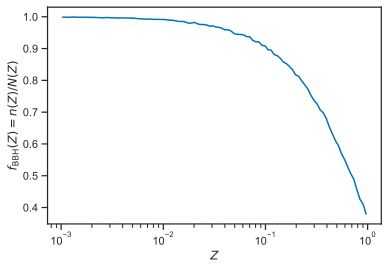

In [7]:
plot(Zs, ns/Ns)
xlabel(r"$Z$")
ylabel(r"$f_\mathrm{BBH}(Z) = n(Z) / N(Z)$")
xscale('log')

Now let's try our MCMC.  Because successive samples are correlated in the outputs, I'm going to thin by a factor of 100 (take 1M samples, but save only every 100 outputs); probably I should also remove the "burnin" (the part at the beginning where you retain memory of the initial point), but our particular proposal for generating new points burns in very quickly (since proposed points are actually independent of the current location).

In [8]:
ibins, js, zs, Zs = zip(*[x for (x, i) in zip(mergers_uniform_proposal(Zs, dZs, Ns, ns, mu_logZ, sigma_logZ), tqdm.tqdm(range(1000000))) if i%100 == 0])

100%|██████████| 1000000/1000000 [01:07<00:00, 14862.83it/s]


Because the BH formation efficiency is so much higher at low metallicity, and because mean metallicity decreases sharply with redshift, we see the pattern below.  At low $z$, the scatter in the metallicity is large, but the mean metallicity is large and the SFR is smaller, so we see a moderate number of BBH at all metallicities; at intermediate $z$ the mean metallicity has decreased somewhat, but the SFR is higher, so there are more "trials" to explore the metallicity distribution, and we continue to see large scatter; at $z > 3$, the SFR is lower, so the metallicity-specific SFR contracts to be close to the decreasing mean of the $Z$ distribution because we have fewer "trials" to explore the tails.

To smooth things out, I randomly distributed the $Z$ values of the BBH mergers uniformly within the corresponding $Z$ bin (if you don't do this, the scatterplot is full of distracting horizontal stripes.

(0.0, 7.0)

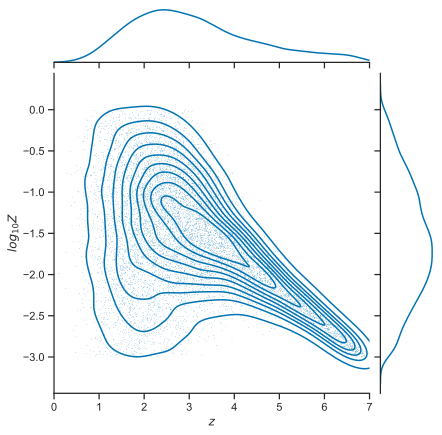

In [9]:
g = sns.JointGrid(x=zs, y=log10([np.random.uniform(low=Zbins[i], high=Zbins[i+1]) for i in ibins]))
g.plot_joint(sns.scatterplot, s=0.3)
g.plot_joint(sns.kdeplot)
g.plot_marginals(sns.kdeplot)

g.set_axis_labels(xlabel=r'$z$', ylabel=r'$log_{10} Z$')
g.ax_joint.set_xlim(0,7)

g.ax_marg_x.set_xlim(0,7)

The above plot shows how we could estimate the *density* of BBH merger formation metallicity and redshifts (to include a formation-to-merger delay, just map $z_\mathrm{form}$ to $z_\mathrm{merge}$ probabilistically---but I am not going to implement this complication here).  To estimate the overall rate, $R$, which is the normalization constant in front of the probability density that gives the *intensity*
$$
\frac{\mathrm{d}N}{\mathrm{d} z \mathrm{d} \log_{10} Z} = R p\left( z, \log_{10} Z \right),
$$
we can connect the star formation rate implied by the M-D distribution to the total amout of star formation in our MCMC chain; the rate is given by the number of BBH in our chain (i.e. its length) times times the amount of formation from the M-D distribution divided by the total amount of formation in the chain:
$$
R = \frac{N_\mathrm{MCMC}}{\sum_{k=1}^{N_\mathrm{MCMC}} \frac{N_{i_k}}{n_{i_k}}} N_{\mathrm{MD}}.
$$
Here $N/n$ is the amount of star formation per black hole in the bin corresponding to MCMC draw $k$; since we produce one BBH per sample in the chain, the sum is the total amount of star formation required to produce the chain.

In [10]:
z = expm1(linspace(log(1), log(1+10), 1024))
N_MD = trapz(md(z)*Planck18.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value*4*pi, z)
R = len(ibins) / sum([Ns[i]/ns[i] for i in ibins]) * N_MD

We get an exceptionally high rate because our efficiency is close to 100% on a SFR of 1 / Gpc^3 / yr at $z = 0$.

In [11]:
print('R = {:.2f} / Gpc^3 / yr'.format(R))

R = 12366.52 / Gpc^3 / yr
